In [3]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

import kmos_tools as KT
import matplotlib as mpl

from astropy.io import fits
from astropy.wcs import WCS
from astropy.utils.data import get_pkg_data_filename
from astropy import units as u
from astropy.convolution import Gaussian2DKernel, convolve
import photutils
from lmfit.models import GaussianModel, SkewedGaussianModel


mpl.rcParams['font.size'] = 18

import logging

logging.getLogger().setLevel(logging.WARNING)

c=3.e5

# Find observed z_spec > 5 objects and plot their Bin spectra

# Objects on slits

In [4]:
slits = pd.read_csv('masks/BLAS_1_slits.csv')

# fits file ext # = slits.index + 1
slits['extnum'] = slits.index + 1

pri1_slits = slits[slits.priority == 1]
# pri1_slits.reset_index(drop=True, inplace=True)
pri1_slits

,slit,targetnum,name,ra,dec,pmra,pmdec,mag,priority,epoch,type,wave_start,wave_end,side,extnum
15,3,10,Stark11_43_3982,189.039261,62.247654,0,0,0.001,1,2000,TARGET,7718.780538,10241.372704,A,16
19,255,1916,f_3,188.910191,62.352588,0,0,0.001,1,2000,STANDARD,6855.558347,9378.533932,A,20
20,254,1915,f_2,188.902346,62.363999,0,0,0.001,1,2000,STANDARD,6773.112436,9296.124509,A,21
49,4,11,Jung18_z6_GND_5752,189.199585,62.320965,0,0,0.001,1,2000,TARGET,7592.815993,10115.463032,A,50
63,1,7,Hu10_z6_4,189.253998,62.353954,0,0,0.001,1,2000,TARGET,7509.007141,10031.694313,A,64
64,2,8,Stark11_35_22248,189.253998,62.353954,0,0,0.001,1,2000,TARGET,7509.007141,10031.694313,A,65
65,5,19,Stark11_35_22381,189.255386,62.357750,0,0,0.001,1,2000,TARGET,7489.939970,10012.635887,A,66
78,6,9,Hu10_z6_3,189.055939,62.129990,0,0,0.001,1,2000,TARGET,7402.424921,9925.164452,B,79
83,13,23,Stark11_42_6706,189.079712,62.141884,0,0,0.001,1,2000,TARGET,7421.763890,9944.492681,B,84
89,12,22,Stark11_41_13100,189.156693,62.115440,0,0,0.001,1,2000,TARGET,7115.139790,9638.003378,B,90


## Get zspec from literature data

In [5]:
pri1_tab = pd.read_csv('targets/target_lists/pri1_knownLAEs_cat_matchFinkelstein.dat', delimiter='\t', escapechar='#', skiprows=1)
pri1_tab

,ID,ra,dec,ID_Fink,z_Lya,z_Fink,Reference
0,Hu10_z6_5,189.399719,62.239494,z5_GND_22781,-99.000,5.33,Hu10
1,Hu10_z6_11,189.365982,62.196171,z5_GND_37006,-99.000,5.39,Hu10
2,Hu10_z6_12,189.320312,62.233444,z5_GND_24948,-99.000,5.43,Hu10
3,Hu10_z6_9,189.342285,62.262852,z5_GND_14430,-99.000,5.51,Hu10
4,Hu10_z6_7,189.032761,62.143970,z5_GNW_6135,5.640,5.01,Hu10
5,Hu10_z6_6,189.324554,62.299732,z5_GNW_23799,5.663,5.44,Hu10
6,Hu10_z6_4,189.253998,62.353954,z5_GNW_32160,-99.000,5.51,Hu10
7,Stark11_35_22248,189.253998,62.353954,z5_GNW_32160,5.700,5.51,Stark11
8,Hu10_z6_3,189.055939,62.129990,z5_GNW_3960,5.635,5.52,Hu10
9,Stark11_43_3982,189.039261,62.247654,z6_GND_21202,5.710,5.57,Stark11


# Match with slits

In [6]:
zspec = np.zeros(len(pri1_slits))
for i, slit in pri1_slits.iterrows():
    pri1_tab_match = pri1_tab[pri1_tab['ID'] == slit['name']]
    if len(pri1_tab_match) > 0:
        zspec[i] = pri1_tab_match['z_Lya']

pri1_slits['zspec'] = zspec
pri1_slits['Lya_wave'] = (zspec+1)*121.6
pri1_highz = pri1_slits.sort_values(by='extnum')[pri1_slits['zspec'] > 5]

pri1_highz[['extnum','name','ra','dec','side', 'zspec','Lya_wave']]

/home/cmason/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/home/cmason/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,extnum,name,ra,dec,side,zspec,Lya_wave
0,16,Stark11_43_3982,189.039261,62.247654,A,5.710,815.9360
3,50,Jung18_z6_GND_5752,189.199585,62.320965,A,6.583,922.0928
5,65,Stark11_35_22248,189.253998,62.353954,A,5.700,814.7200
6,66,Stark11_35_22381,189.255386,62.357750,A,5.700,814.7200
7,79,Hu10_z6_3,189.055939,62.129990,B,5.635,806.8160
8,84,Stark11_42_6706,189.079712,62.141884,B,5.970,847.5520
9,90,Stark11_41_13100,189.156693,62.115440,B,5.810,828.0960
10,108,Stark11_42_13066,189.156387,62.197666,B,5.610,803.7760
11,115,Stark11_32_16773,189.197800,62.199982,B,5.970,847.5520
12,118,Jung18_z6_GND_28438,189.177979,62.223713,B,6.551,918.2016


In [237]:
def plot_2Dspec(f, target=16, vmin_sig=-0.5, vmax_sig=3., wave_Lya=8300., title=None,
                smooth=None, wave_d=50, obposval=None, pos_d=10):
    
    hdu_list = fits.open(f)

    hdu = hdu_list[target]
    wcs = WCS(hdu.header)

    image = hdu.data

    spec_med = np.nanmedian(image, axis=0)
#     image -= spec_med
    
    wmin_nm = hdu.header['CRVAL1']
    wmax_nm = hdu.header['CRVAL1']+(hdu.header['NAXIS1']-1)*hdu.header['CDELT1']
    waveA   = 10*np.arange(wmin_nm, wmax_nm, step=hdu.header['CDELT1'])
    extent = [waveA.min(), waveA.max(),
              0.5, image.shape[0]-0.5]
    
    if smooth:
        kernel = Gaussian2DKernel(smooth)
    
    imcentered = convolve(image, kernel).copy()
    index_centered = np.where(np.abs(waveA - wave_Lya) > wave_d/2)
    
    imsky      = imcentered.copy()
    imsky[10:-10] = np.nan
    noise = np.nanstd(imsky, axis=0)
    
#     plt.figure()
#     plt.plot(waveA, noise)
#     plt.axhline(2*np.nanmedian(noise), c='tab:orange')
#     plt.axhline(2*np.std(noise))
#     plt.xlim((wave_Lya - wave_d), (wave_Lya + wave_d))
#     plt.ylim(0.,10.)
#     plt.axvline(wave_Lya, ymin=0.6, ymax=1., lw=5, c='tab:orange')
    
    imcentered[:,index_centered] = np.nan    
    imcentered[:,np.where(noise > 1.*np.nanmedian(noise))] = np.nan    
    
    fig = plt.figure(figsize=(14,5))
    ax = fig.add_subplot(111)#, projection=wcs)
    ax.annotate(title, xy=(0.,0.94), xycoords='axes fraction')
    
    if smooth:
        implot = convolve(image, kernel)
    else:
        implot = image
    im = ax.imshow(implot, origin='lower', cmap='Greys', aspect='equal', extent=extent,
                  vmin=vmin_sig*np.nanstd(image), vmax=vmax_sig*np.nanstd(image))
    

    tab = photutils.detection.find_peaks(imcentered, threshold=1.*np.nanstd(imcentered),
                                         box_size=20, npeaks=1, subpixel=False,
                                         border_width=10)    
    ax.axvline(wave_Lya, ymin=0.6, ymax=1., lw=5, c='tab:orange')
    
    if obposval:
        ax.axhline(obposval, lw=2,  ls='dashed', c='tab:orange')
    ax.axhline(image.shape[0]/2, lw=2,  ls='dashed', c='tab:blue')
    
    try:
        ax.plot(waveA[tab['x_peak']], tab['y_peak'], 'o', c='r', ms=20, mfc='none', mew=2)
        ax.axhline(tab['y_peak'], lw=2,  ls='dashed', c='tab:red')
        posy = tab['y_peak']
    except:
        posy = obposval  
    
    ax.axhline(posy+pos_d, lw=2,  ls='dotted', c='tab:red')
    ax.axhline(posy-pos_d, lw=2,  ls='dotted', c='tab:red')
    
    ax.set_xlim((wave_Lya - wave_d), (wave_Lya + wave_d))
    ax.set_xlabel('Wavelength [$\mathrm{\AA}$]')
    ax.set_ylabel('Position [pixels]')
    
    return waveA, image, posy
            
def plot_1Dspec(waveA, image, wave_Lya, StoN=False,
                pos_min=None, pos_max=None, pos_med=None, pos_d=10, wave_d=50,
                med_subtract=True, title=None):
    
    if pos_med is None:
        pos_med = image.shape[0]/2
    else: 
        pos_med = int(pos_med)
    
    if pos_min:
        pos_min = int(pos_min)
    else:
        pos_min = pos_med - pos_d
    if pos_max:
        pos_max = int(pos_max)
    else:
        pos_max = pos_med + pos_d
    
    if med_subtract:
        spec_med = np.nanmedian(image, axis=0)
        image -= spec_med
        
    Npix = pos_max - pos_min
        
    spec1D = np.nansum(image[pos_min:pos_max], axis=0)
    err_image = image.copy()
    err_image[pos_min-4:pos_max+4] = np.nan
    err1D  = np.sqrt(Npix)*np.nanstd(err_image, axis=0)    
    
    Sin = spec1D[np.where(np.abs(waveA - wave_Lya) < wave_d)]
    Nin = err1D[np.where(np.abs(waveA - wave_Lya) < wave_d)]
    
    plt.figure(figsize=(14,5))

    ax = plt.subplot(111)

    if StoN:

        StoN = spec1D/err1D
        ax.plot(waveA, StoN, drawstyle='steps-mid', lw=3, label='S/N')
        
        dwaveA= np.median(np.diff(waveA))
        smooth_pix = 3
#         ax.plot(waveA, KT.smooth_boxcar_simple(StoN, smooth_pix), lw=3, label='S/N smoothed by %.1f$\mathrm{\AA}$' % np.round(smooth_pix*dwaveA,1))
        
        norm_err1D = err1D/np.nanmax(Nin)     
        ax.fill_between(waveA, -3, KT.smooth_boxcar_simple(norm_err1D-3, 3),#-3., 
                        color='0.7', zorder=0, label='Scaled noise')
        
        # Gaussian
        mod = GaussianModel()
    
        x = waveA[np.where(np.abs(waveA - wave_Lya) < wave_d)]
        y = np.nan_to_num(Sin/Nin)
        
        pars = mod.guess(y, x=x)
        out = mod.fit(y, pars, x=x)
#         print(out.fit_report(min_correl=0.25))
        ax.plot(x, out.best_fit)
        print out.params['height']
        
        # half gaussian        
        gmodel = Model(half_gauss)
        params = gmodel.make_params()
        params.add('totalSN', expr='amp * FWHM * 1.06 / 2.')

        result = gmodel.fit(y, x=x, params=params,
                            amp=out.params['height'].value, 
                            cen=out.params['center'].value, 
                            FWHM=out.params['fwhm'].value)
        print(result.fit_report(min_correl=0.25))
        
        ax.plot(x, result.best_fit)
        
        ax.set_ylim(-3, 1.1*np.nanmax(Sin/Nin))
        
        ax.set_ylabel('S/N')
        
    else:
        ax.plot(waveA, spec1D, c='tab:orange', drawstyle='steps-mid', lw=3, label='Flux')
        ax.fill_between(waveA, -err1D, err1D, color='0.7', step='mid', zorder=0, label='Noise')
        ax.set_ylim(-3*np.nanstd(Sin), 3*np.std(Sin))
        
        ax.set_ylabel('Flux [uncalib]')
    
#     ax.annotate(title, xy=(0.,0.94), xycoords='axes fraction')
#     ax.axvline(wave_Lya, ymin=0.6, ymax=1., lw=2, c='k', ls='dashed', label='Literature $z_\mathrm{spec}$')
    ax.annotate(r'$z_{\mathrm{Ly}\alpha} = %.2f$' % (wave_Lya/1216.-1.), xy=(0.01,0.9), xycoords='axes fraction')
    ax.axhline(0., lw=1, c='0.1', zorder=0)
    
    # km/s axis
    ax_kms = ax.twiny()
    
    def wave_to_kms(wave, mu0):
        return c*(wave-mu0)/mu0
    
    ax_kms.plot(wave_to_kms(waveA, wave_Lya), spec1D, color='k', lw=0, ls='dashed')

    ax.set_xlim((wave_Lya - wave_d), (wave_Lya + wave_d))
    ax_kms.set_xlim(wave_to_kms(np.array(ax.get_xlim()), wave_Lya))

    ax_kms.set_xlabel('Velocity [km/s]', labelpad=10)
    ax.set_xlabel('Wavelength [$\mathrm{\AA}$]')
    
    
    ax.legend()

    return

In [238]:
print np.sqrt(2.*np.pi)/2.355
from scipy.optimize import curve_fit
from lmfit import Model
def half_gauss(x, amp, cen, FWHM):
    sig = FWHM/2.355
    gauss = amp * np.exp(-0.5*(x-cen)**2 / sig**2.)
    gauss[x<cen] = 0.
    return gauss

1.0643856792488324


(174, 5632)
<Parameter 'height', value=6.280943497133066 +/- 0.58, bounds=[-inf:inf], expr='0.3989423*amplitude/max(1.e-15, sigma)'>
[[Model]]
    Model(half_gauss)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 46
    # data points      = 97
    # variables        = 3
    chi-square         = 72.2640039
    reduced chi-square = 0.76876600
    Akaike info crit   = -22.5553299
    Bayesian info crit = -14.8311969
[[Variables]]
    amp:      6.09925978 +/- 0.76423149 (12.53%) (init = 6.280943)
    cen:      9220.16083 +/- 1.02985026 (0.01%) (init = 9221.456)
    FWHM:     5.93989247 +/- 1.58341134 (26.66%) (init = 2.727349)
    totalSN:  19.2013420 +/- 6.72801282 (35.04%) == 'amp * FWHM * 1.06 / 2.'
[[Correlations]] (unreported correlations are < 0.250)
    C(cen, FWHM) = -0.921
    C(amp, cen)  = -0.739
    C(amp, FWHM) =  0.539

<Parameter 'height', value=8.382521328696614 +/- 0.692, bounds=[-inf:inf], expr='0.3989423*amplitude/max(1.e-15, sigma)'>
[[Model

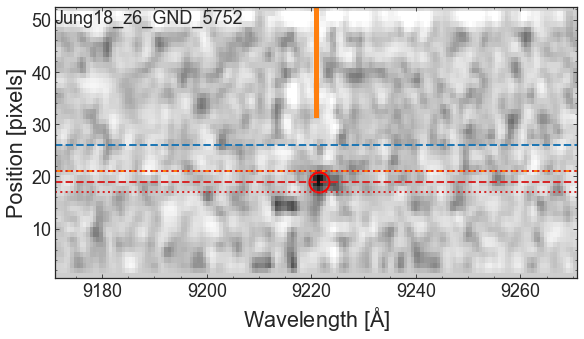

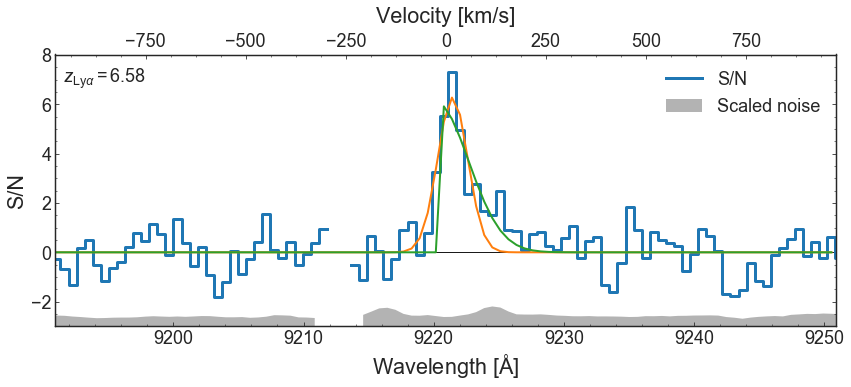

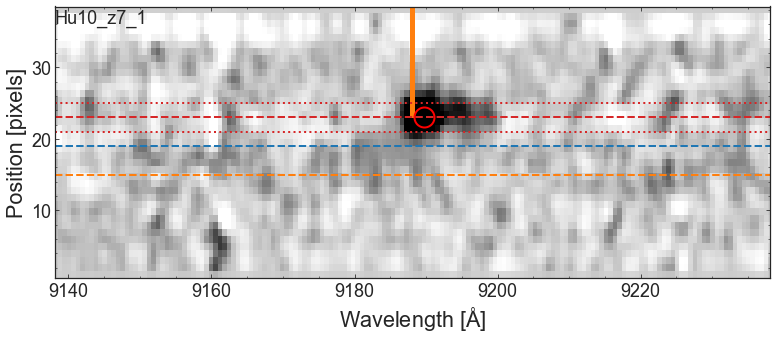

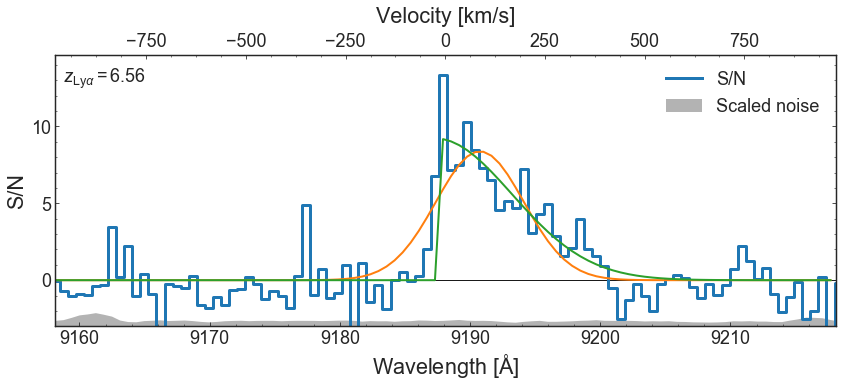

In [239]:
datadir = '/h/hobnob0/Binospec/2649_BLAS_1a_2019.0208/2019.0208_red_4hrs_190219/'
fname_data = datadir+"obj-sky_slits_lin.fits"
fname_extr = datadir+"obj_abs_slits_extr.fits"

filename  = get_pkg_data_filename(fname_data)
extract1D = fits.open(fname_extr)
# filename = get_pkg_data_filename('/h/hobnob0/Binospec/2649_BLAS_1a_2019.0208/2019.0208_red_4hrs_190219/obj_counts_slits_lin.fits')

spec1D = extract1D['FLUX'].data
err1D = extract1D['ERROR'].data
print spec1D.shape

# FWHM from stars = 4 pixels

pos_d  = 2
wave_d = 50
for ss, s in pri1_highz.iterrows():
    
    if ss == 15 or ss==3:
        obpos = 'OBPOS%s' % s['extnum'] #each OBPOSVAL has a different name based on the slit idx
        obposval = extract1D[1].header[obpos]
        obposval = int(obposval) #need to convert to int for slicing

        title = s['name']

        if 'Hu' in title:
            s['zspec'] = s['zspec']-0.003
        wave_Lya = 1216. * (1. + s['zspec'])
        waveA, image, posy = plot_2Dspec(filename, target=s['extnum'], wave_Lya=wave_Lya, 
                                         smooth=1.,wave_d=wave_d, title=title,
                                         vmin_sig=-0.3, vmax_sig=0.7, 
                                         obposval=obposval, pos_d=pos_d)

        plot_1Dspec(waveA, image, wave_Lya=wave_Lya, title=title, 
                    pos_d=pos_d, pos_med=posy, wave_d=30,
                   StoN=True)
        
#         plt.figure(figsize=(14,5))
#         plt.plot(waveA, spec1D[s['extnum']-1])
#         plt.xlim((wave_Lya - 50), (wave_Lya + 50))

21
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 37
    # variables        = 3
    chi-square         = 4.4865e+10
    reduced chi-square = 1.3196e+09
    Akaike info crit   = 779.892092
    Bayesian info crit = 784.724846
[[Variables]]
    sigma:      1.68144653 +/- 0.01749311 (1.04%) (init = 1.5)
    center:     21.0535977 +/- 0.01749312 (0.08%) (init = 21.5)
    amplitude:  12055642.7 +/- 108618.590 (0.90%) (init = 1.279724e+07)
    fwhm:       3.95950393 +/- 0.04119313 (1.04%) == '2.3548200*sigma'
    height:     2860338.25 +/- 25771.0271 (0.90%) == '0.3989423*amplitude/max(1.e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.250)
    C(sigma, amplitude) =  0.577



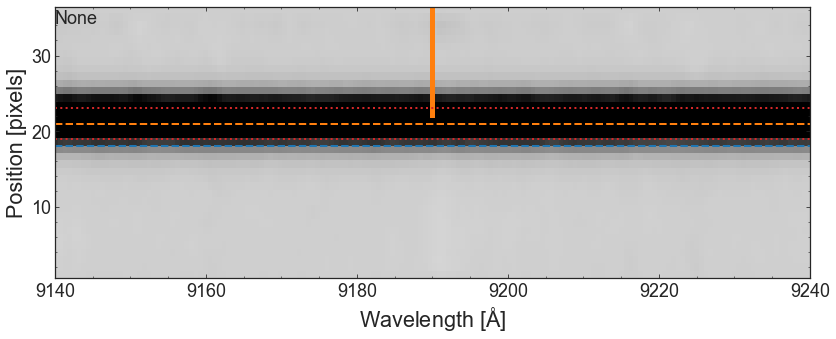

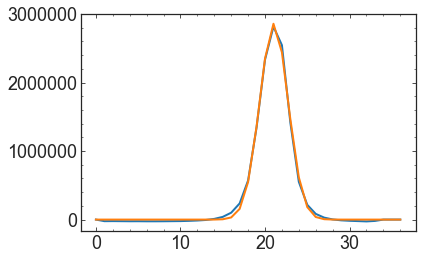

In [233]:
# Measure psf from stars

s['extnum'] = 21

obpos = 'OBPOS%s' % s['extnum'] #each OBPOSVAL has a different name based on the slit idx
obposval = extract1D[1].header[obpos]
obposval = int(obposval) #need to convert to int for slicing
print obposval      
waveA, image, posy = plot_2Dspec(filename, target=s['extnum'], wave_Lya=9190, 
                                         smooth=1.,wave_d=wave_d,
                                         vmin_sig=-0.3, vmax_sig=0.7, 
                                         obposval=obposval, pos_d=pos_d)

spec_pos = np.nansum(image, axis=1)
plt.figure()
plt.plot(spec_pos)

x =np.arange(len(spec_pos))
y = spec_pos

from lmfit.models import GaussianModel, SkewedGaussianModel

mod = GaussianModel()

pars = mod.guess(y, x=x)
out = mod.fit(y, pars, x=x)
print(out.fit_report(min_correl=0.25))

plt.plot(x, out.best_fit)